# Model training

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
## data ingestion
#import libraries and creating connection with Mongodb
import pymongo
import json
import pickle as pk

client = pymongo.MongoClient("localhost")
print(client)
#defining database and collection
db = client["Regression"]
collection = db["household_power_consumption_pickles"]

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)


### Fetching pickled data

In [3]:
result = tuple(collection.find({},{"_id":0}))

### Reading scaler object

In [4]:
scaler = pk.loads(result[0].get("scaler_obj"))
scaler

StandardScaler()

### Reading train data

In [5]:
## fetching training data
train_data = result[1].get("Train_data")
x_train = pk.loads(train_data[0])
y_train = pk.loads(train_data[1])
print(x_train.shape)
print(y_train.shape)

(10050, 5)
(10050,)


In [6]:
x_train

array([[-0.84369277,  0.25634068,  0.09358889, -0.8444995 ,  0.46133945],
       [ 0.02105447,  0.32773141,  0.05625804,  0.00681677,  0.16868898],
       [-0.86818452, -1.08223554,  0.10920689, -0.88930562,  0.46133945],
       ...,
       [-0.79282529, -1.08223554,  0.10958782, -0.79969338,  0.75398993],
       [-0.76833353, -0.15415603,  0.22081852, -0.75488726,  0.16868898],
       [-0.85688064, -1.08223554, -0.0907798 , -0.8444995 , -0.1239615 ]])

### Reading test data

In [7]:
## fetching test data
test_data = result[2].get("Test_data")
x_test = pk.loads(test_data[0])
y_test = pk.loads(test_data[1])
print(x_test.shape)
print(y_test.shape)

(4950, 5)
(4950,)


## Decision Tree Regressor Model training

In [11]:
## creating regression model and training it
from sklearn.tree import DecisionTreeRegressor
dtr_model = DecisionTreeRegressor()
dtr_model.fit(x_train,y_train)

DecisionTreeRegressor()

In [12]:
##standardization of test data
x_test = scaler.transform(x_test)
x_test

array([[-0.80789713,  0.14925458,  0.20596236, -0.79969338,  0.16868898],
       [ 0.05308215,  0.79177116,  0.14082384,  0.05162289,  0.75398993],
       [ 0.20380062, -0.20769908,  0.08178015,  0.18604125,  1.33929088],
       ...,
       [-0.64775876, -0.45756664,  0.09320796, -0.66527502, -0.41661198],
       [ 0.39219871, -0.56465274,  0.06768585,  0.36526573, -1.58721388],
       [-0.74760974,  0.0243208 ,  0.15644185, -0.75488726,  0.16868898]])

In [13]:
## testing of model
dtr_pred = dtr_model.predict(x_test)
dtr_pred

array([ 1.,  2.,  1., ...,  1., 19.,  0.])

In [14]:
## checking accuracy by MSE,MAE,RMSE,R2 and ajusted R2 error
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
print("Mean absolute error: ",mean_absolute_error(y_test,dtr_pred))
print("Mean square error: ",mean_squared_error(y_test,dtr_pred))
print("r2 score: ",r2_score(y_test,dtr_pred))

Mean absolute error:  3.6084848484848484
Mean square error:  68.7090909090909
r2 score:  0.5649475878523351


In [50]:
#Adjusted R2 score
r2 = r2_score(y_test,dtr_pred)
N = x_train.shape[0] + x_test.shape[0]
P = x_train.shape[1]
adjusted_r2 = (1 - ((1-r2)*(N-1)))/(N-P-1)
print("Adjusted r2: ", adjusted_r2)

Adjusted r2:  -0.43513079430457685


Model performance is very Bad as adjusted r2 is negative

### Our model is over fitted as score for train data is 100% and testing data is 36%

### Decision tree regressor Model score is 36%

## Finding best parameters for the model using gridsearchcv

In [77]:
from sklearn.model_selection import GridSearchCV
             
grid_param = {
    'criterion': ["squared_error", "friedman_mse"],
    'max_depth' : range(2,10,1),
    'min_samples_leaf' : range(1,8,1),
    'min_samples_split': range(2,8,1),
    'splitter' : ['best', 'random']
    
}

In [78]:
gscv = GridSearchCV(estimator=dtr_model,
             param_grid=grid_param,verbose=2)

In [79]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=1, min_sample

[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=7, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=7, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=2, min_samples_leaf=7, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion

[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=7, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=7, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=7, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=7, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=7, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=7, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion

[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion

[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=5, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=5, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=5, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=5, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=5, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=6, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=6, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=6, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=6, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=6, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=6, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=6, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=6, min_samples_leaf=6, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=3, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=3, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=3, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=3, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=3, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=3, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=3, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=3, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=4, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=4, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=4, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=4, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=4, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion

[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=7, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion

[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion

[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion

[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criteri

[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END crite

[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=7, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=7, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=7, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=9, min_samples_leaf=7, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END crite

[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=1, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=3, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=3, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=4, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=6, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=2, min_samples_leaf=7, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=fried

[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=3, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=3, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=2, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=4, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=5, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=5, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=5, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=5, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=5, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=5, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=5, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=5, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=4, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=1, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=3, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=fried

[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=5, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=7, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=7, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=5, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=1, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=1, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=fried

[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=6, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=6, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=6, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=6, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=6, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=6, min_samples_leaf=7, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=fried

[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=3, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=3, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=fried

[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=4, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=fried

[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=5, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=5, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=7, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=7, min_samples_leaf=7, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=fried

[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=1, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=1, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=2, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=3, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=4, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=6, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=8, min_samples_leaf=7, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=fried

[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=1, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=2, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=3, min_samples_split=7, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=4, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=4, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=5, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=5, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=5, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=friedma

[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=6, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=6, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=fri

[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=7, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=7, min_samples_split=6, splitter=best; total time=   0.0s
[CV] END criterion=friedman_mse, max_depth=9, min_samples_leaf=7, min_samples_split=6, splitter=random; total time=   0.0s
[CV] END criterion=friedma

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse'],
                         'max_depth': range(2, 10),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 8),
                         'splitter': ['best', 'random']},
             verbose=2)

In [80]:
gscv.best_estimator_

DecisionTreeRegressor(criterion='friedman_mse', max_depth=8, min_samples_leaf=4,
                      min_samples_split=4, splitter='random')

In [81]:
dtr_model2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=8, min_samples_leaf=4,
                      min_samples_split=4, splitter='random')

In [82]:
dtr_model2.fit(x_train,y_train)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=8, min_samples_leaf=4,
                      min_samples_split=4, splitter='random')

In [83]:
dtr_model2.score(x_train,y_train)

0.7856499214515626

In [84]:
pred2 = dtr_model2.predict(x_test)

In [85]:
pred2

array([ 0.85407725,  4.18518519, 12.70731707, ...,  0.61578947,
       15.58695652,  0.72074468])

In [86]:
## checking accuracy by MSE,MAE,RMSE,R2 and ajusted R2 error
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
print("Mean absolute error: ",mean_absolute_error(y_test,pred2))
print("Mean square error: ",mean_squared_error(y_test,pred2))
print("r2 score: ",r2_score(y_test,pred2))

Mean absolute error:  3.1181015880195204
Mean square error:  39.20790062227144
r2 score:  0.7517433062309918


our r2 score increased.
and MSE decreased

[Text(0.511766975308642, 0.9444444444444444, 'X[3] <= -0.216\nfriedman_mse = 166.017\nsamples = 10050\nvalue = 8.816'),
 Text(0.2605131172839506, 0.8333333333333334, 'X[1] <= -0.105\nfriedman_mse = 1.453\nsamples = 5553\nvalue = 0.817'),
 Text(0.12789351851851852, 0.7222222222222222, 'X[1] <= -0.239\nfriedman_mse = 0.798\nsamples = 3264\nvalue = 0.521'),
 Text(0.06674382716049383, 0.6111111111111112, 'X[3] <= -0.329\nfriedman_mse = 0.731\nsamples = 2755\nvalue = 0.468'),
 Text(0.029320987654320986, 0.5, 'X[1] <= -0.594\nfriedman_mse = 0.451\nsamples = 2684\nvalue = 0.437'),
 Text(0.009259259259259259, 0.3888888888888889, 'X[2] <= -3.616\nfriedman_mse = 0.331\nsamples = 1772\nvalue = 0.349'),
 Text(0.006172839506172839, 0.2777777777777778, 'friedman_mse = 0.0\nsamples = 119\nvalue = 0.0'),
 Text(0.012345679012345678, 0.2777777777777778, 'X[0] <= -0.634\nfriedman_mse = 0.346\nsamples = 1653\nvalue = 0.374'),
 Text(0.006172839506172839, 0.16666666666666666, 'X[4] <= -0.883\nfriedman_mse =

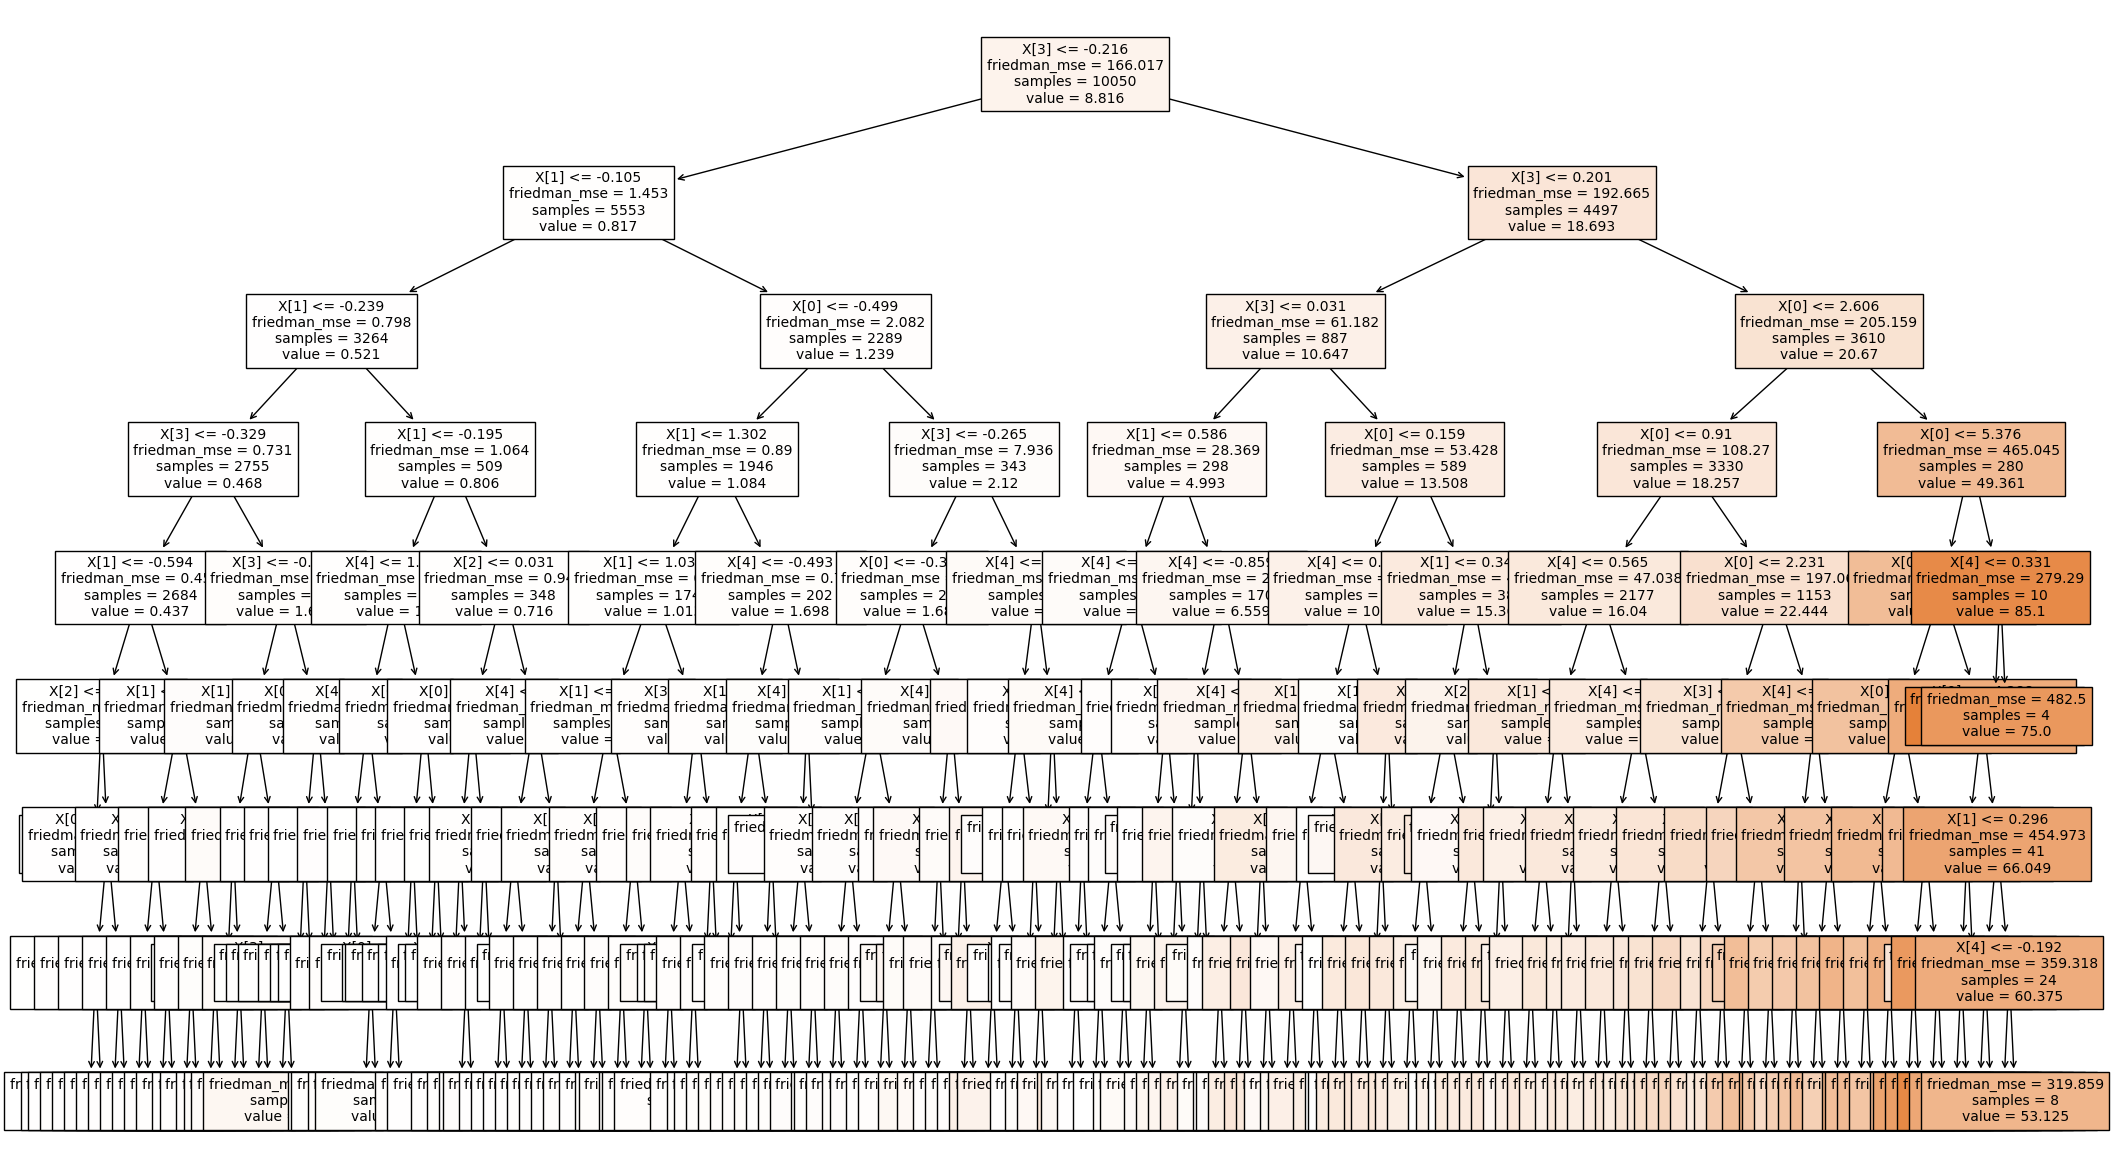

In [88]:
from sklearn import tree
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(25,15))
tree.plot_tree(dtr_model2,filled=True,fontsize=10)

In [89]:
fig.savefig("tree.png")